## PyTorch workflow

Let's explore a an example PyTorch end-to-end workflow.




In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6 : "putting it all together"}

what_were_covering


{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.8.0+cu126'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning

* Excel speedsheet
* Images of any kind
* Videos (Youtube has lots of data..)
* Audio like song and podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a traning and test sets with our data.

In [4]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

how might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize"

In [5]:
def plot_predictions(train_data =X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot traninig data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Traning data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

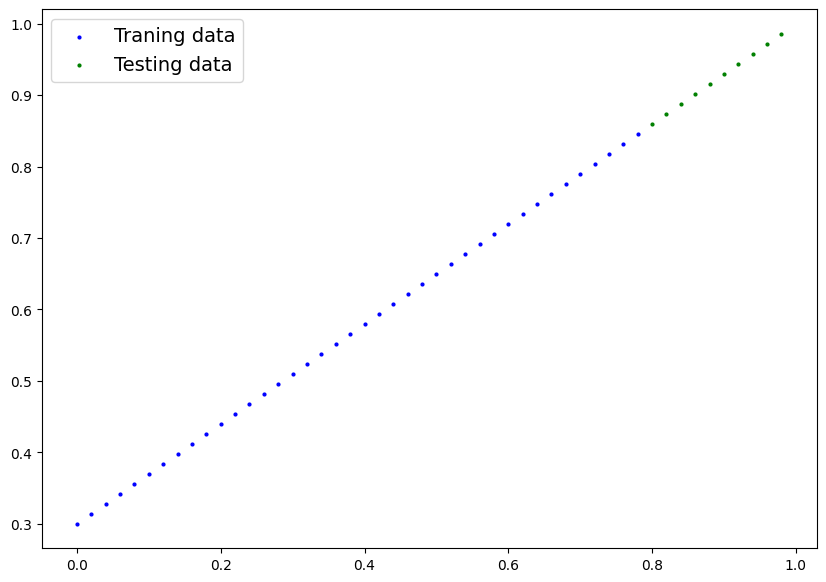

In [6]:
plot_predictions()

## 2. Build model

Our first PyTorch model!

This is very exciting... let's do it!

What our model does:
* Start with random values (weight & bias)
* Look at traning data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [7]:
from torch import nn
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inheritsh from nn.Module
  def __init__(self):
    super().__init__()
    # Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

    # Forward methot to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the building for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network models, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation


### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside out model using `.parameters()`.

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create a instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the model parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List name parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the forward() method.

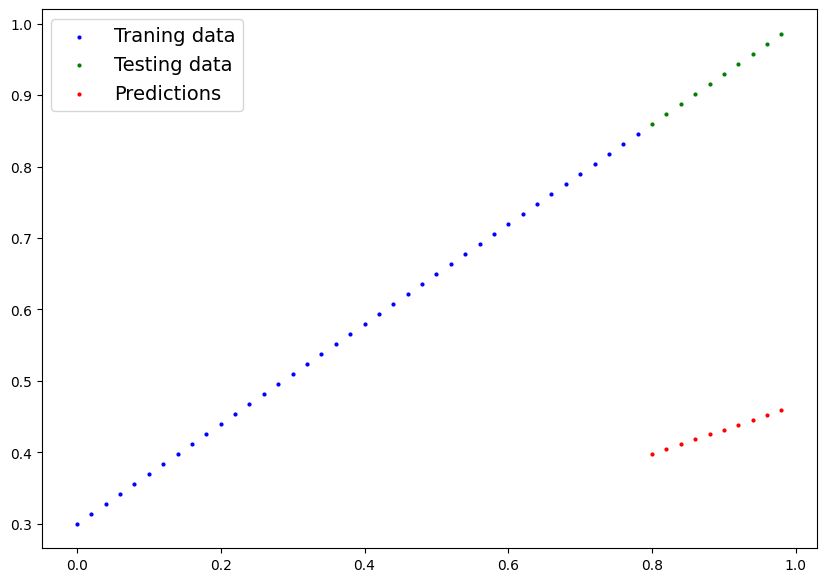

In [10]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad(), however, torch.inference_mode() is preffered
# with torch.no_grad():
#   y_preds = model_0(X_test)
# Plot predictions and target
plot_predictions(predictions=y_preds)

### 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better
representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss or a model and adjusts the model's
parameters (e.g. weight & bias in our case) to improve the loss function.

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [11]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [12]:
# Check out or model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [13]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = possibily the most important hyperparameter you can set


**Q:** Which loss functionn and optimizer should I use=

**A:** This will be problem specific. But with exprience, you'll get an idea of what works and what doesn't with your particular problem set.

For example, for a regression problem (like ours), a loss function of nn.L1Loss() and an optimizer like torch.optim.SGD() will suffice.

But for a classification problem like classifiying whether a photo is of a dog or a cat, you'll likely want to use a loss function of nn.BCELoss() (binary cross entropy loss).

### Building a traninig loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop throught the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Clculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [14]:
torch.manual_seed(42)
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 200
epoch_count = []
loss_values = []
test_loss_values = []
### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training model
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the odel
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate throught the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing

  model_0.eval(); # turns off different setting in the model note needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

  # Print out model state_dict()
 # print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

In [15]:
import numpy as np

/tmp/ipython-input-1959932132.py:2: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Train loss")


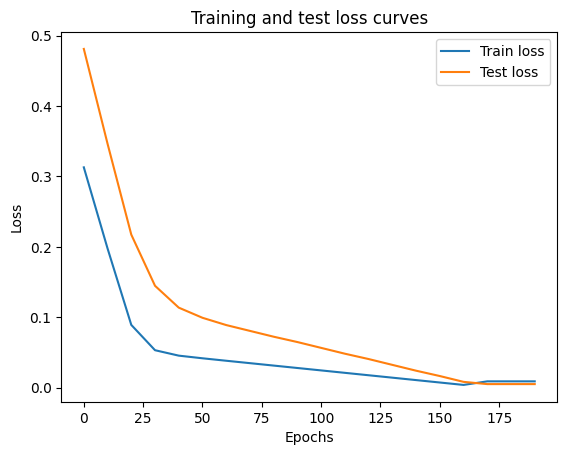

In [16]:
# plot the loss curves
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

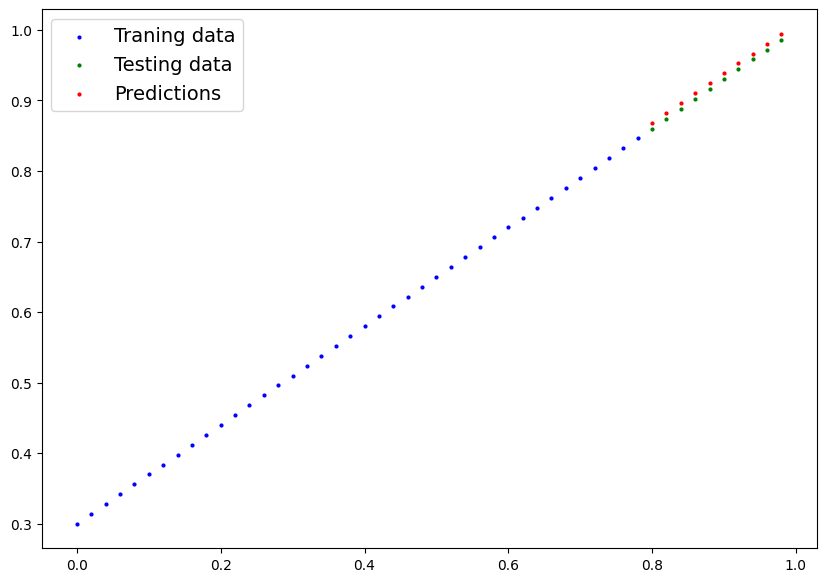

In [17]:
with torch.inference_mode():
  y_preds0 = model_0(X_test)

plot_predictions(predictions=y_preds0)

## Saving a model in PyTorch

There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [18]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than entire model, we'll create a instance of our model class and load the saved `state_dict()` into that

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [20]:
# To load in saved state_dict we have to instantiate a new instance our model class
loaded_model_0 = LinearRegressionModel()
# Load the saved state_dict of model_0 (this will update the new instane with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

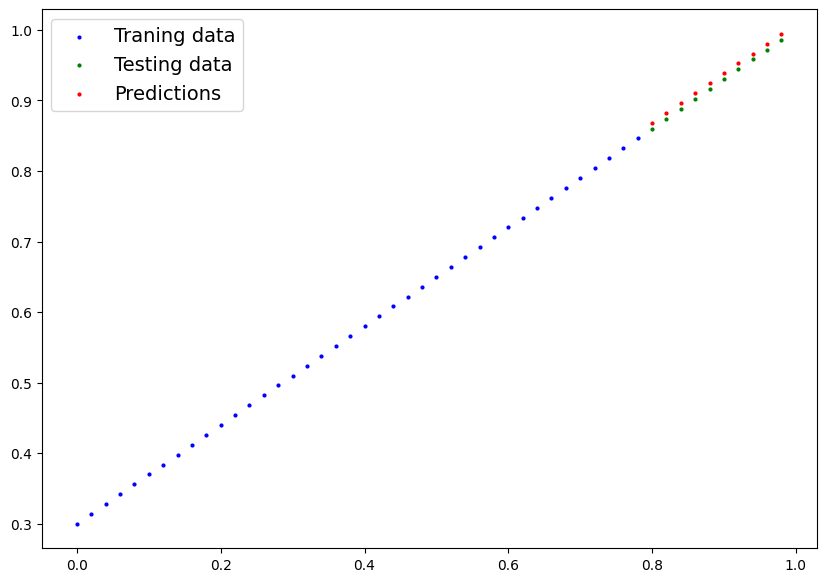

In [22]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

# Plot the predictions
plot_predictions(predictions=loaded_model_preds)


# 6. Putting it all together

Let's go back through the steps above and see it all in one place

In [23]:
# Import PyTorch and matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn


# Check PyTorch version
torch.__version__

'2.8.0+cu126'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [24]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6.1 Data

In [25]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [26]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

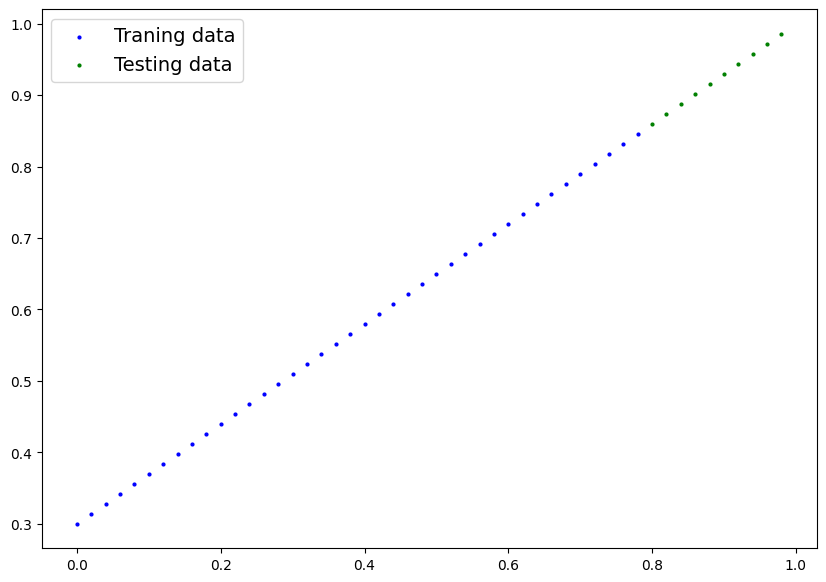

In [27]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch Linear Model

In [28]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [29]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [30]:
# Set the model to use tha target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Traninig

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [31]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [32]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200
epoch_count = []
loss_values = []
test_loss_values = []
# Pu data on the target device (device agnostic code for data)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Training loop
for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_1(X_test)

    # 2. Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [33]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evaluating predictions


In [34]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions
with torch.inference_mode():
  y_preds1 = model_1(X_test)

y_preds1

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

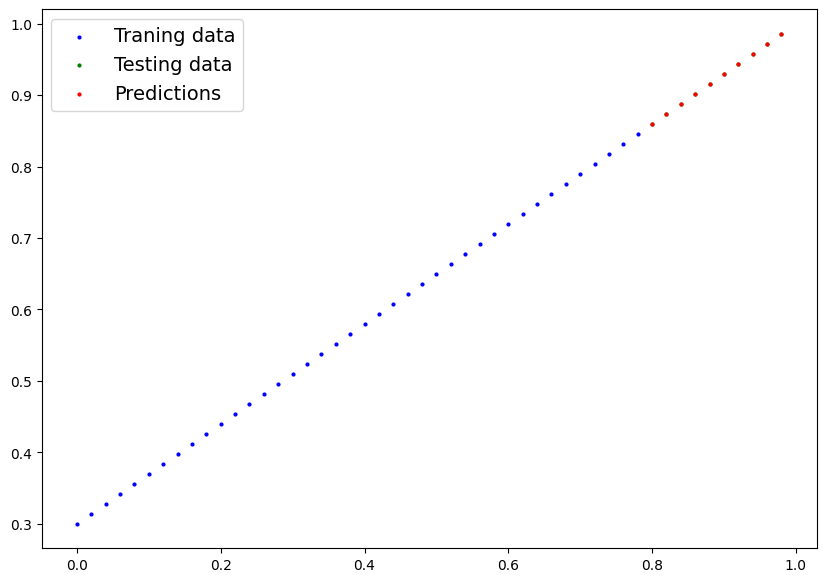

In [35]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds1.cpu())

## 6.5 Saving & and loading a trained model

In [36]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_NAME = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_NAME}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_NAME)


Saving model to: models/01_pytorch_workflow_model_1.pth


In [37]:
# Load a PyTorch model

# Create a new instance of linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_NAME))

# put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [38]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [39]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

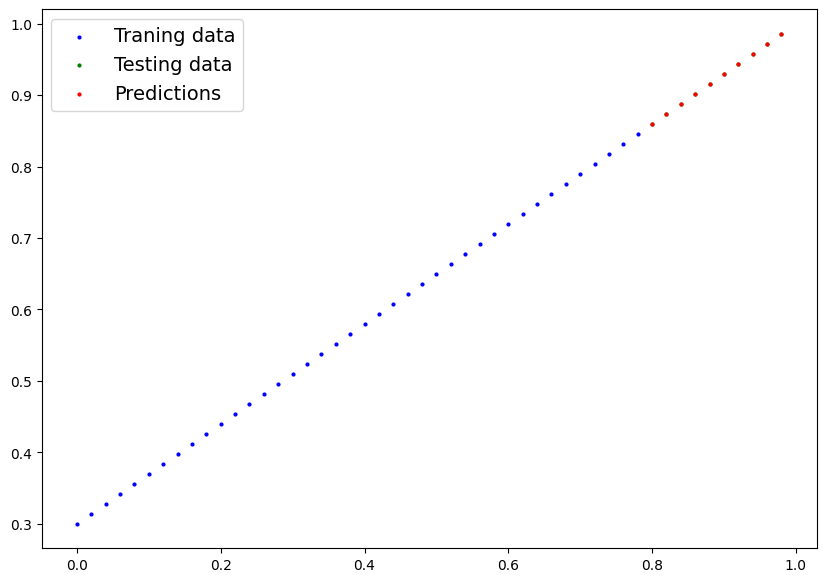

In [40]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

# Plot the predictions
plot_predictions(predictions=loaded_model_1_preds.cpu())


# Exercise

In [41]:
# create parameters
weight = 0.3
bias = 0.9
start = 0
end = 2.5
step = 0.02

# create X & y data
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.9000],
         [0.9060],
         [0.9120],
         [0.9180],
         [0.9240],
         [0.9300],
         [0.9360],
         [0.9420],
         [0.9480],
         [0.9540]]))

In [42]:
# split train and test data
train_test_split = len(X) * 0.8
X_train, y_train = X[:int(train_test_split)], y[:int(train_test_split)]
X_test, y_test = X[int(train_test_split):], y[int(train_test_split):]

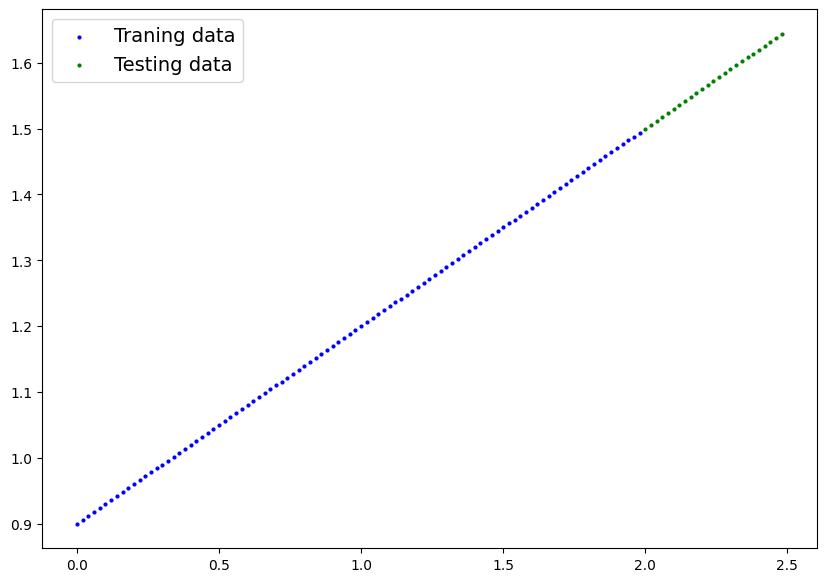

In [43]:
plot_predictions(X_train, y_train, X_test, y_test)

In [48]:
# create a model

class LinearRegressionModelv3(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype = torch.float))

  def forward(self, x: torch.Tensor) ->   torch.Tensor:
    return self.weights * x + self.bias

In [49]:
torch.manual_seed(42)
model_3 = LinearRegressionModelv3()
model_3.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [61]:
# create loss & optimizer
loss_v3 = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.01)

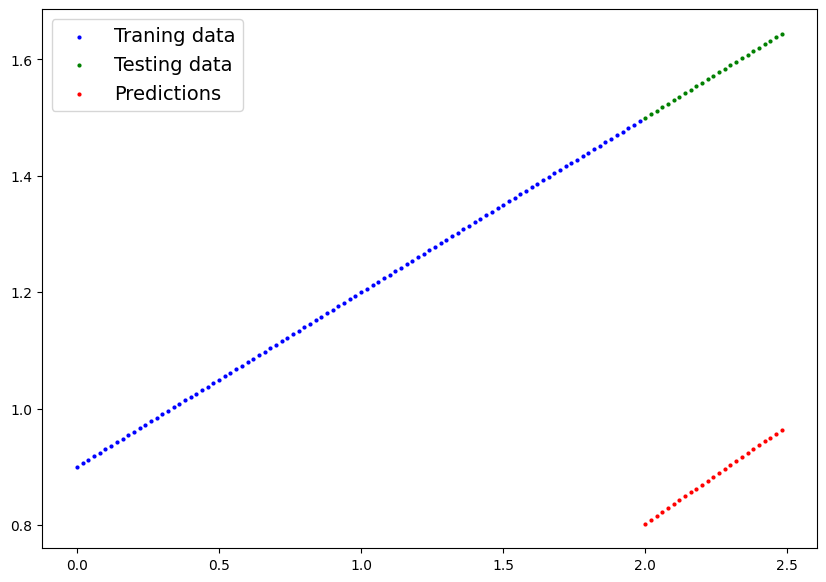

In [56]:
with torch.inference_mode():
  y_preds3 = model_3(X_test)

plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds3)

In [63]:
epoch = 300

for epoch in range(epoch):
  model_3.train()

  y_pred = model_3(X_train)

  loss = loss_v3(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()

  if(epoch % 20 == 0):
    with torch.inference_mode():
      y_preds3 = model_3(X_test)

      test_loss = loss_v3(y_preds3, y_test)
    print(f"Epoch: {epoch} | Train loss:{loss} | Test loss:{test_loss}" )


Epoch: 0 | Train loss:0.715066134929657 | Test loss:0.6246521472930908
Epoch: 20 | Train loss:0.3190461993217468 | Test loss:0.03460017591714859
Epoch: 40 | Train loss:0.18101684749126434 | Test loss:0.2780839204788208
Epoch: 60 | Train loss:0.15669651329517365 | Test loss:0.2791793644428253
Epoch: 80 | Train loss:0.13438589870929718 | Test loss:0.24375253915786743
Epoch: 100 | Train loss:0.11214692890644073 | Test loss:0.20297445356845856
Epoch: 120 | Train loss:0.08990795165300369 | Test loss:0.1621963381767273
Epoch: 140 | Train loss:0.06766960024833679 | Test loss:0.12218271195888519
Epoch: 160 | Train loss:0.04543062299489975 | Test loss:0.08140461146831512
Epoch: 180 | Train loss:0.02319164201617241 | Test loss:0.04062650725245476
Epoch: 200 | Train loss:0.01368201058357954 | Test loss:0.005272822454571724
Epoch: 220 | Train loss:0.01368201058357954 | Test loss:0.005272822454571724
Epoch: 240 | Train loss:0.01368201058357954 | Test loss:0.005272822454571724
Epoch: 260 | Train los

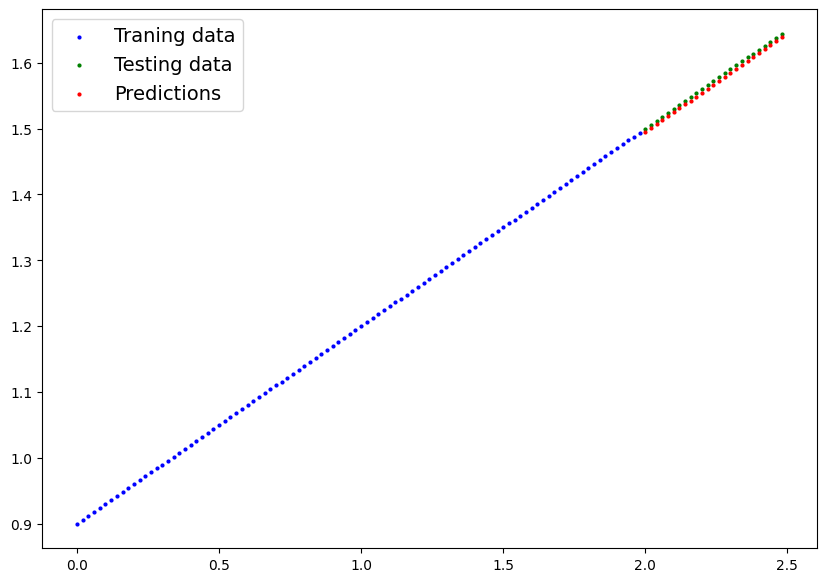

In [71]:
plot_predictions(
                  train_data=X_train.detach().numpy(),
                  train_labels=y_train.detach().numpy(),
                  test_data=X_test.detach().numpy(),
                  test_labels=y_test.detach().numpy(),
                  predictions=y_preds3.detach().numpy()
              )




In [72]:
from pathlib import Path

# save model

MODEL_PATH = Path("models")

MODEL_NAME = "01_pytorch_workflow_model_3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_3.pth')

In [73]:
print(f"Saving model in {MODEL_SAVE_PATH}")
torch.save(obj = model_3.state_dict(),
           f= MODEL_SAVE_PATH)


Saving model in models/01_pytorch_workflow_model_3.pth
